In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from indicnlp.tokenize import indic_tokenize
import pickle
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
import json
import os
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



In [2]:
def convert_json_to_parquet(input_file, output_file):
    with open(input_file, 'r') as file:
        data = json.load(file)
    rows = []
    for i, row in enumerate(data):
        rows.append({
            'id': i,
            'tokens': row['tokens'],
            'ner_tags': row['ner_tags']
        })
    df = pd.DataFrame(rows)
    df.to_parquet(output_file, index=False)
convert_json_to_parquet('train.json','train-00000-of-00001.parquet')
convert_json_to_parquet('test.json','test-00000-of-00001.parquet')
convert_json_to_parquet('validation.json','validation-00000-of-00001.parquet')


In [3]:

def analyze_parquet_file(file_path):
    data = pd.read_parquet(file_path)
    print(f"First few rows of the data from {file_path}:")
    print(data.head(3))
    print("\nDataframe structure:")
    print(data.info())


# List of Parquet files to analyze
files_to_analyze = [
    'train-00000-of-00001.parquet',
    'test-00000-of-00001.parquet',
    'validation-00000-of-00001.parquet'
]

for file in files_to_analyze:
    analyze_parquet_file(file)


First few rows of the data from train-00000-of-00001.parquet:
   id                                             tokens  \
0   0  [इस, क़ानून, का, कई, संगठनों, ने, विरोध, किया,...   
1   1  [देर, रात, तक, जुहू, चौपाटी, में, यह, नजारा, आ...   
2   2  [रामनगर, इगलास, ,, अलीगढ़, ,, उत्तर, प्रदेश, स...   

                                            ner_tags  
0  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...  
1        [22, 22, 22, 4, 15, 22, 22, 22, 22, 22, 22]  
2           [4, 4, 22, 4, 22, 4, 15, 22, 22, 22, 22]  

Dataframe structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75827 entries, 0 to 75826
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        75827 non-null  int64 
 1   tokens    75827 non-null  object
 2   ner_tags  75827 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None
First few rows of the data from test-00000-of-00001.parquet:
   id                                    

In [4]:

file_path = 'train-00000-of-00001.parquet' 
data = pd.read_parquet(file_path)
examples_per_tag = {}
for index, row in data.iterrows():
    tokens = row['tokens']
    ner_tags = row['ner_tags']

    for token, tag in zip(tokens, ner_tags):
        if tag not in examples_per_tag:
            examples_per_tag[tag] = []
        if len(examples_per_tag[tag]) < 20:
            examples_per_tag[tag].append(token)
for tag, examples in examples_per_tag.items():
    print(f"NER Tag {tag} examples: {examples}")


NER Tag 22 examples: ['इस', 'क़ानून', 'का', 'कई', 'संगठनों', 'ने', 'विरोध', 'किया', 'था', 'और', 'कहा', 'था', 'कि', 'इस', 'क़ानून', 'का', 'दायरा', 'इतना', 'व्यापक', 'है']
NER Tag 4 examples: ['जुहू', 'रामनगर', 'इगलास', 'अलीगढ़', 'उत्तर', 'झारखण्ड', 'तिरुवूरु', 'कृष्णा', 'भारत', 'आन्ध्रप्रदेश', 'कृष्णा', 'मुंबई', 'पश्चिम', 'बिहार', 'भागलपुर', 'मध्य', 'उत्तर', 'कानपुर', 'अमरीका', 'इलिनॉय']
NER Tag 15 examples: ['चौपाटी', 'प्रदेश', 'बंगाल', 'प्रदेश', 'प्रदेश', 'बंगाल', 'राज्य', 'अमेरिका', 'सैण', 'साहिब', 'खुर्द', 'प्रदेश', 'घाटी', 'लैंलूगा', 'कश्मीर', 'प्रदेश', 'मंदिर', 'पतियासार', 'N.Z.A.', 'धारा']
NER Tag 6 examples: ['दूसरे', 'दोनों', '10', '20', 'एक', 'तीसरे', 'एक', 'एक', 'एक', 'अरबों', 'सात', '10', 'दूसरे', '25', 'बीस', 'सात', 'एक', 'एक', 'एक', 'एक']
NER Tag 10 examples: ['1978', 'गुरुवार', 'शाम', 'वर्ष', 'छह', 'शुक्रवार', 'रात', '2003', 'मंगलवार', 'गुरुवार', '37', '२००९', '1994', 'बारह', '1971', '2006', 'सोमवार', '1997', 'रविवार', '28']
NER Tag 2 examples: ['हिन्दी', 'हिन्दी', 'हिन्द

## This is not Explicitly mentioned in dataset so deducing this from the above examples

• NER Tag 0: Festivals and celebrations (e.g., Christmas, Holi, Valentine's Day)

• NER Tag 1: Sports (e.g., cricket, tennis, Twenty20, Test match) 

• NER Tag 2: Languages (e.g., Hindi, English, French, Urdu)

• NER Tag 3: Literary works, philosophical concepts, or places (e.g., Gita, Ramayana, Mahabharata, city, ocean)

• NER Tag 4: Towns, cities, states, and countries (e.g., Juhu, Aligarh, Jharkhand, America)

• NER Tag 5: Nationalities and regional identities (e.g., American, Pakistani, Indian, Punjabi)

• NER Tag 6: Numbers and ranks (e.g., two, three, 10, 20, crores, billions) 

• NER Tag 7: Organizations, political parties, and media outlets (e.g., BJP, BBC, Congress, CBI)

• NER Tag 8: Person names (e.g., Gambhir, Sanjay, Jaswant, Advani)

• NER Tag 9: Religions and religious groups (e.g., Muslim, Hindu, Christian, Sikh, Brahmin)

• NER Tag 10: Dates, times, years, and ages (e.g., 1978, Thursday, 2009, six years old, 5:30)

• NER Tag 11: Religious events and film festivals (e.g., puja, Janmashtami, Navratri, film festival)

• NER Tag 12: Sports events and tournaments (e.g., series, match, league, Masters)

• NER Tag 13: The word "language" (भाषा) 

• NER Tag 14: Literary and artistic works, professions, and abstract concepts (e.g., poetry, geographer, loneliness)

• NER Tag 15: Place types and landforms (e.g., valley, temple, province, N.Z.A., clause)

• NER Tag 16: Groups of people and residents (e.g., cricketers, Indians, Sentinelese, Brahmins)

• NER Tag 17: Units of measurement (e.g., lakh, thousand, percent, meter, seats)

• NER Tag 18: Government, military and institutional entities (e.g., court, Congress, soldiers, team, ministry)

• NER Tag 19: Indian and Pakistani last names (e.g., Dutt, Singh, Hussain, Gilani, Kiyani)

• NER Tag 20: The word "religion" (धर्म) and names of religions (e.g., Buddhism)

• NER Tag 21: Time periods and dates (e.g., year, months, century, decades, o'clock)

• NER Tag 22: Common Noun

In [5]:
train_file_path = 'train-00000-of-00001.parquet'
test_file_path = 'test-00000-of-00001.parquet'
val_file_path = 'validation-00000-of-00001.parquet'

train_data = pd.read_parquet(train_file_path)
test_data = pd.read_parquet(test_file_path)
val_data = pd.read_parquet(val_file_path)

Token Length Statistics:
Max Length: 180
Mean Length: 20.38
Standard Deviation: 12.39
Percentiles:
0.25    11.0
0.50    18.0
0.75    26.0
0.90    37.0
0.95    44.0
0.99    63.0
Name: tokens, dtype: float64


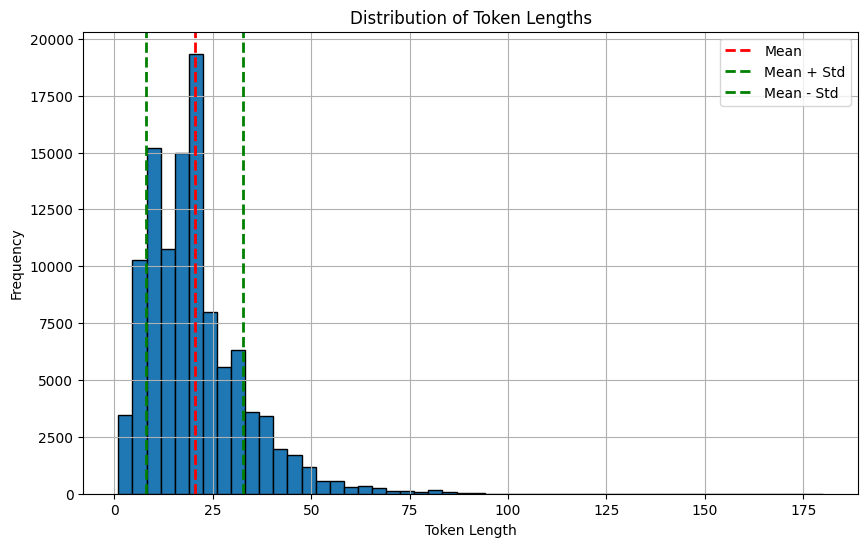

In [6]:


train_token_lengths = train_data['tokens'].apply(len)
test_token_lengths = test_data['tokens'].apply(len)
val_token_lengths = val_data['tokens'].apply(len)


all_token_lengths = pd.concat([train_token_lengths, test_token_lengths, val_token_lengths])

max_length = all_token_lengths.max()
mean_length = all_token_lengths.mean()
std_length = all_token_lengths.std()
percentiles = all_token_lengths.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

print("Token Length Statistics:")
print(f"Max Length: {max_length}")
print(f"Mean Length: {mean_length:.2f}")
print(f"Standard Deviation: {std_length:.2f}")
print("Percentiles:")
print(percentiles)
plt.figure(figsize=(10, 6))
plt.hist(all_token_lengths, bins=50, edgecolor='black')
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_length + std_length, color='green', linestyle='dashed', linewidth=2, label='Mean + Std')
plt.axvline(mean_length - std_length, color='green', linestyle='dashed', linewidth=2, label='Mean - Std')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
class ElmoProcessor(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,wt_mat):
        super(ElmoProcessor,self).__init__()
        self.lstmf1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmf2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        self.embedding=wt_mat.to(device)
        self.lstmb1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmb2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        self.linear=nn.Linear(hidden_dim,vocab_size)
    def forward(self, embeddingdata):
        emb = torch.tensor(self.embedding(embeddingdata.to(device)))
        emb_f = emb
        o1f1, h1f1 = self.lstmf1(emb_f)
        o2f2, h2f2 = self.lstmf2(o1f1)
        output = self.linear(o2f2)
        return (output, o1f1, o2f2)

In [8]:
with open('word_to_ix.pkl', 'rb') as file:
    word_to_ix = pickle.load(file)

forward_model_path = "pretrained_forward_model"
backward_model_path = "pretrained_backward_model"
forward_model = torch.load(forward_model_path, map_location=torch.device('cpu'))
backward_model = torch.load(backward_model_path, map_location=torch.device('cpu'))

# Pad the token sequences to a fixed length
max_length = 40
def pad_sequence(tokens, max_length, padding_value):
    padded_tokens = tokens[:max_length] + [padding_value] * (max_length - len(tokens))
    return padded_tokens
# Create a mapping between NER tags and integer labels
unique_tags = set()
for tags in train_data['ner_tags']:
    unique_tags.update(tags)

tag_to_idx = {tag: idx for idx, tag in enumerate(unique_tags)}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

# Convert tokens to integer indices and NER tags to integer labels
def convert_to_indices(tokens, tags, word_to_ix, tag_to_idx, max_length):
    token_indices = [word_to_ix.get(token, word_to_ix['<UNK>']) for token in tokens]
    tag_indices = [tag_to_idx[tag] for tag in tags]
    padded_token_indices = pad_sequence(token_indices, max_length, word_to_ix['<PAD>'])
    padded_tag_indices = pad_sequence(tag_indices, max_length, tag_to_idx[0])
    return padded_token_indices, padded_tag_indices

class NERDataset(Dataset):
    def __init__(self, data, word_to_ix, tag_to_idx, max_length):
        self.data = data
        self.word_to_ix = word_to_ix
        self.tag_to_idx = tag_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tokens = self.data.iloc[index]['tokens']
        tags = self.data.iloc[index]['ner_tags']
        token_indices, tag_indices = convert_to_indices(tokens, tags, self.word_to_ix, self.tag_to_idx, self.max_length)
        return torch.tensor(token_indices), torch.tensor(tag_indices)



In [9]:
# Define the NER model architecture
class ElmoNERClassifier(nn.Module):
    def __init__(self, forward_model, backward_model, embedding_dim, num_tags):
        super(ElmoNERClassifier, self).__init__()
        self.forward_model = forward_model
        self.backward_model = backward_model
        self.embedding = forward_model.embedding
        self.forward_model.requires_grad = False
        self.backward_model.requires_grad = False
        self.param0 = nn.Parameter(torch.rand(1), requires_grad=True)
        self.param1 = nn.Parameter(torch.rand(1), requires_grad=True)
        self.param2 = nn.Parameter(torch.rand(1), requires_grad=True)
        self.bilstm = nn.LSTM(input_size=embedding_dim*2, hidden_size=256, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256 * 2, num_tags)

    def forward(self, x):
        _, o1f1, o2f2 = self.forward_model(x)
        _, o1b1, o2b2 = self.backward_model(x)
        embdata = self.embedding(x)
        e = torch.cat([embdata, embdata.flip(1)], dim=2)
        h1 = torch.cat([o1f1, o1b1.flip(1)], dim=2)
        h2 = torch.cat([o2f2, o2b2.flip(1)], dim=2)
        out, _ = self.bilstm(self.param0 * e + self.param1 * h1 + self.param2 * h2)
        out = self.fc(out)
        return out
    
# Create data loaders
train_dataset = NERDataset(train_data, word_to_ix, tag_to_idx, max_length)
test_dataset = NERDataset(test_data, word_to_ix, tag_to_idx, max_length)
val_dataset = NERDataset(val_data, word_to_ix, tag_to_idx, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the NER model
embedding_dim = 300
hidden_size = 256
num_tags = len(tag_to_idx)
model = ElmoNERClassifier(forward_model, backward_model, embedding_dim, num_tags).to(device)



model_name = "prediction"

if os.path.exists(f"{model_name}.pt"):
    model.load_state_dict(torch.load(f"{model_name}.pt"))
    print(f"Loaded trained model: {model_name}.pt")
else:
    criterion = nn.CrossEntropyLoss(ignore_index=tag_to_idx[0])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for i, (token_indices, tag_indices) in enumerate(train_loader):
            token_indices = token_indices.to(device)
            tag_indices = tag_indices.to(device)
            outputs = model(token_indices)
            loss = criterion(outputs.view(-1, num_tags), tag_indices.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            total_loss += loss.item()
        model.eval()

        with torch.no_grad():
            val_loss = 0
            val_true_labels = []
            val_pred_labels = []
            for i, (token_indices, tag_indices) in enumerate(val_loader):
                token_indices = token_indices.to(device)
                tag_indices = tag_indices.to(device)
                outputs = model(token_indices)
                loss = criterion(outputs.view(-1, num_tags), tag_indices.view(-1))
                val_loss += loss.item()
                predicted_labels = torch.argmax(outputs, dim=2).view(-1)
                val_true_labels.extend(tag_indices.view(-1).tolist())
                val_pred_labels.extend(predicted_labels.tolist())
            val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_true_labels, val_pred_labels, average='weighted')
            val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
            scheduler.step(val_f1)        
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')
    torch.save(model.state_dict(), f"{model_name}.pt")

Epoch [1/10], Train Loss: 0.1498, Val Loss: 0.1109
Epoch [2/10], Train Loss: 0.0977, Val Loss: 0.1054
Epoch [3/10], Train Loss: 0.0814, Val Loss: 0.1046
Epoch [4/10], Train Loss: 0.0668, Val Loss: 0.1099
Epoch [5/10], Train Loss: 0.0536, Val Loss: 0.1162
Epoch [6/10], Train Loss: 0.0420, Val Loss: 0.1301
Epoch [7/10], Train Loss: 0.0331, Val Loss: 0.1455
Epoch [8/10], Train Loss: 0.0190, Val Loss: 0.1671
Epoch [9/10], Train Loss: 0.0125, Val Loss: 0.1833
Epoch [10/10], Train Loss: 0.0107, Val Loss: 0.1994


Test Accuracy: 0.4735, Test F1: 0.3211


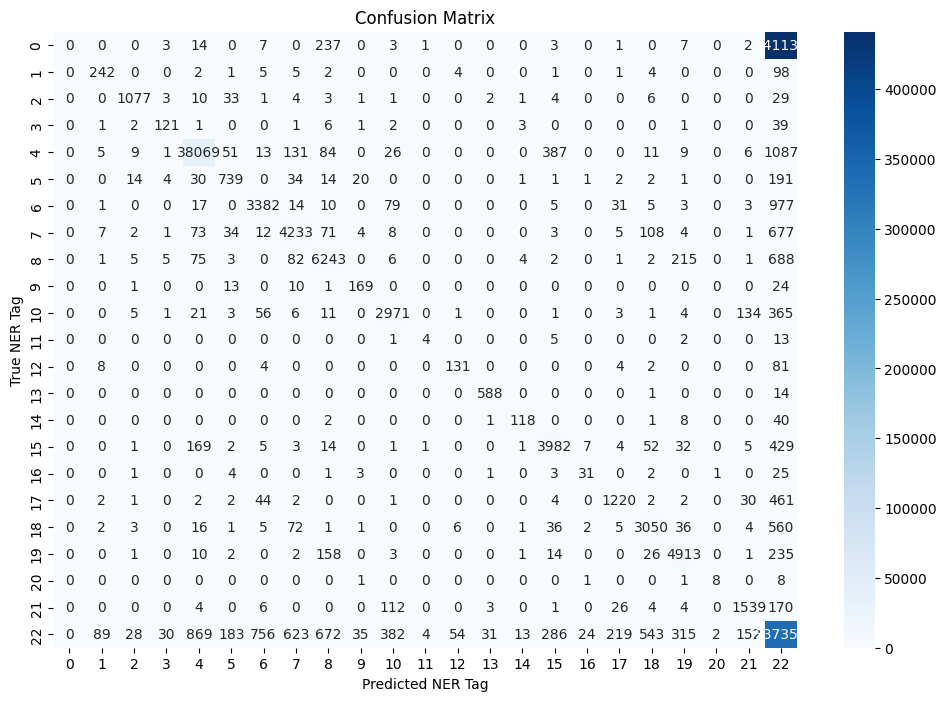

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    441412
           1       0.68      0.66      0.67       365
           2       0.94      0.92      0.93      1175
           3       0.72      0.68      0.70       178
           4       0.97      0.95      0.96     39889
           5       0.69      0.70      0.70      1054
           6       0.79      0.75      0.77      4527
           7       0.81      0.81      0.81      5243
           8       0.83      0.85      0.84      7333
           9       0.72      0.78      0.75       218
          10       0.83      0.83      0.83      3583
          11       0.40      0.16      0.23        25
          12       0.67      0.57      0.62       230
          13       0.94      0.98      0.96       603
          14       0.83      0.69      0.75       170
          15       0.84      0.85      0.84      4708
          16       0.47      0.43      0.45        72
    

In [17]:

import matplotlib.pyplot as plt
def plot_confusion_matrix_and_report(true_labels, pred_labels, idx_to_tag, pad_tag_idx):
    unique_indices = sorted(idx_to_tag.keys())
    filtered_indices = [idx for idx in unique_indices if idx != pad_tag_idx]
    tag_names = [str(idx_to_tag[idx]) for idx in filtered_indices]
    cm = confusion_matrix(true_labels, pred_labels, labels=filtered_indices)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tag_names, yticklabels=tag_names)
    plt.xlabel('Predicted NER Tag')
    plt.ylabel('True NER Tag')
    plt.title('Confusion Matrix')
    plt.show()
    print("Classification Report:")
    print(classification_report(true_labels, pred_labels, labels=filtered_indices, target_names=tag_names))
def evaluate_model(model, data_loader, tag_to_idx, idx_to_tag, pad_tag_idx):
    model.eval()
    test_true_labels = []
    test_pred_labels = []
    with torch.no_grad():
        for i, (token_indices, tag_indices) in enumerate(data_loader):
            token_indices = token_indices.to(device)
            tag_indices = tag_indices.to(device)
            outputs = model(token_indices)
            predicted_labels = torch.argmax(outputs, dim=2).cpu().view(-1)
            tag_indices_flat = tag_indices.view(-1).cpu()
            valid_indices = tag_indices_flat != pad_tag_idx
            test_true_labels.extend(tag_indices_flat[valid_indices].tolist())
            test_pred_labels.extend(predicted_labels[valid_indices].tolist())
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_true_labels, test_pred_labels, average='weighted')
    test_accuracy = accuracy_score(test_true_labels, test_pred_labels)
    print(f'Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')
    plot_confusion_matrix_and_report(test_true_labels, test_pred_labels, idx_to_tag, pad_tag_idx)
PAD_TAG = '<PAD>'
if PAD_TAG not in tag_to_idx:
    pad_tag_idx = len(tag_to_idx)
    tag_to_idx[PAD_TAG] = pad_tag_idx
    idx_to_tag[pad_tag_idx] = PAD_TAG
else:
    pad_tag_idx = tag_to_idx[PAD_TAG]
evaluate_model(model, test_loader, tag_to_idx, idx_to_tag, pad_tag_idx)





In [18]:
import torch
from indicnlp.tokenize import indic_tokenize

tag_to_english = {
    0: "Festivals and celebrations",
    1: "Sports",
    2: "Languages",
    3: "Literary works, philosophical concepts, or places",
    4: "Towns, cities, states, and countries",
    5: "Nationalities and regional identities",
    6: "Numbers and ranks",
    7: "Organizations, political parties, and media outlets",
    8: "Person names",
    9: "Religions and religious groups",
    10: "Dates, times, years, and ages",
    11: "Religious events and film festivals",
    12: "Sports events and tournaments",
    13: "The word 'language' (भाषा)",
    14: "Literary and artistic works, professions, and abstract concepts",
    15: "Place types and landforms",
    16: "Groups of people and residents",
    17: "Units of measurement",
    18: "Government, military and institutional entities",
    19: "Indian and Pakistani last names",
    20: "The word 'religion' (धर्म) and names of religions",
    21: "Time periods and dates",
    22: "Common noun"
}

def predict_ner(text, model, word_to_ix, idx_to_tag, max_length):
    model.load_state_dict(torch.load(f"{model_name}.pt"))
    model.eval()

    tokens = indic_tokenize.trivial_tokenize(text)
    token_indices = [word_to_ix.get(token, word_to_ix['<UNK>']) for token in tokens]
    padded_token_indices = token_indices + [word_to_ix['<PAD>']] * (max_length - len(token_indices))
    input_tensor = torch.tensor(padded_token_indices).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, dim=2)

    predicted_tags = [tag_to_english[idx_to_tag[tag.item()]] for tag in predicted[0] if tag.item() in idx_to_tag]
    return list(zip(tokens, predicted_tags))

text = "मैंने दिल्ली में राजधानी एक्सप्रेस से अहमदाबाद जाने का टिकट बुक करवाया।"
predicted_tags = predict_ner(text, model, word_to_ix, idx_to_tag, max_length)
print(predicted_tags)

[('मैंने', 'Common noun'), ('दिल्ली', 'Towns, cities, states, and countries'), ('में', 'Common noun'), ('राजधानी', 'Common noun'), ('एक्सप्रेस', 'Common noun'), ('से', 'Common noun'), ('अहमदाबाद', 'Towns, cities, states, and countries'), ('जाने', 'Common noun'), ('का', 'Common noun'), ('टिकट', 'Common noun'), ('बुक', 'Common noun'), ('करवाया', 'Common noun'), ('।', 'Common noun')]
